In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.spatial.distance import pdist, cosine
from scipy import stats
from itertools import combinations, permutations
%matplotlib inline

age_classes = ((0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 100))


birth_classes = ((2000, 2018),
                 (1974, 1999),
                 (1969, 1974),
                 (1957, 1968),
                 (1918, 1956))

def age_to_age_class(age, age_classes):
    for lb, ub in age_classes:
        if age >= lb and age <=ub:
            if lb != 65:
                ac = '-'.join((str(lb), str(ub)))
            else:
                ac = '65+'
            break
    return ac

ags = [age_to_age_class(a0, age_classes) for a0, a1 in age_classes]
seasons = [str(s) for s in range(2008, 2019)] + ['2009Pan']
np.random.seed(100)

rcParams['font.sans-serif'] = 'arial'
finaldf = pd.read_csv('../raw_data/Test_status_by_season_age_and_vax.csv')

# Stratified raw data

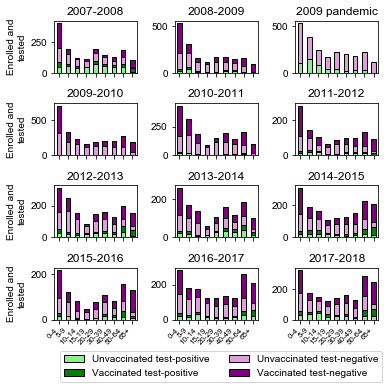

In [3]:
i=1

for season, seasondf in finaldf.groupby('Season'):
    plt.subplot(4,3,i )
    
    t = seasondf.copy()
    t.index = t['Age group']
    t = t.loc[ags, ]
    t.plot.bar(stacked=True,
                      color = ['lightgreen', 'green', 'plum', 'purple'],
                      edgecolor='black', ax=plt.gca(), legend=False)
    plt.ylabel('Enrolled and\ntested')
    plt.xlabel('')
    

    plt.xticks(range(0, len(t)), t['Age group'], rotation=45, ha='right', size=8)
    

    if i not in [10, 11, 12]:
        plt.xticks(range(0, len(t)), [])
    if i not in [1,4,7,10]:
        plt.ylabel('')

    if season != '2009Pan':
        title = '%s-%s'%(int(season) - 1, season)
    else:
        title = '2009 pandemic'
    plt.title(label=title)
    i += 1
    
    
plt.gcf().set_size_inches(5.5,5)
plt.gcf().align_ylabels()
plt.tight_layout()

plt.legend(loc='center', bbox_to_anchor=(-0.9, -0.9), ncol=2)